# Multitaper spectral analysis class interface

The `SHWindow` class provides an interface to compute window functions that concentrate energy spatially in a given region and within a given spherical harmonic bandwidth. This allows to calculate spectral estimates localized to specific regions with the best possible spectral resolution.

To demonstrate, in this example, we will determine the spectrum of the bathymetry of Earth and compare it with that of the surface topography. To this end, we will need to generate window functions that are separately concentrated over the land and the oceans. To start, we read the topography of Earth from the example files, create masks for the oceans and land, and plot the masks:

In [1]:
from __future__ import print_function # only necessary if using Python 2.x
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pyshtools

In [2]:
pyshtools.utils.figstyle(rel_width=0.75)
# %config InlineBackend.figure_format = 'retina'  # if you are using a retina display, uncomment this line

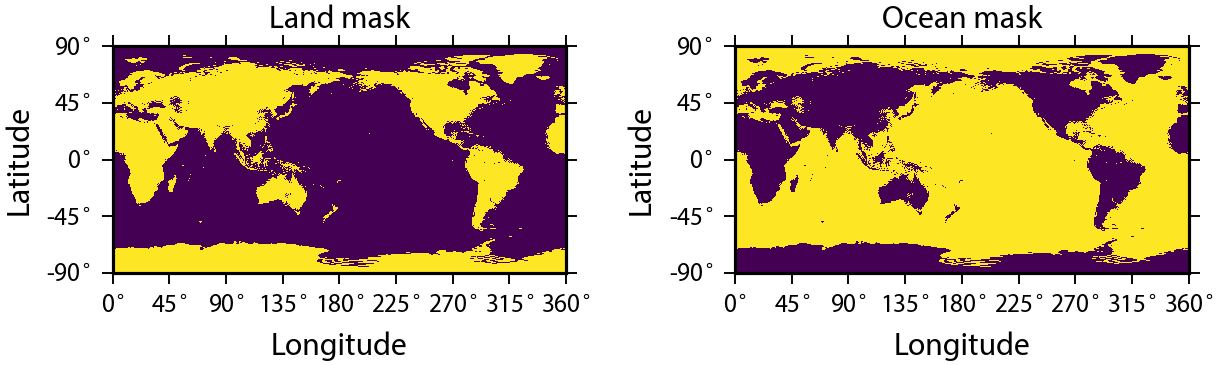

In [3]:
infile = '../ExampleDataFiles/srtmp300.msl'
clm = pyshtools.SHCoeffs.from_file(infile)
topo = clm.expand(grid='DH2')

land_mask = pyshtools.SHGrid.from_array(topo.data > 0)
ocean_mask = pyshtools.SHGrid.from_array(topo.data <= 0)

fig, (col1, col2) = plt.subplots(1, 2)
land_mask.plot(ax=col1, tick_interval=(45, 45), minor_tick_interval=None)
col1.set(title='Land mask')
ocean_mask.plot(ax=col2, tick_interval=(45, 45), minor_tick_interval=None)
col2.set(title='Ocean mask');
fig.tight_layout()

Next, let's plot the masked topography over the oceans and land:

/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


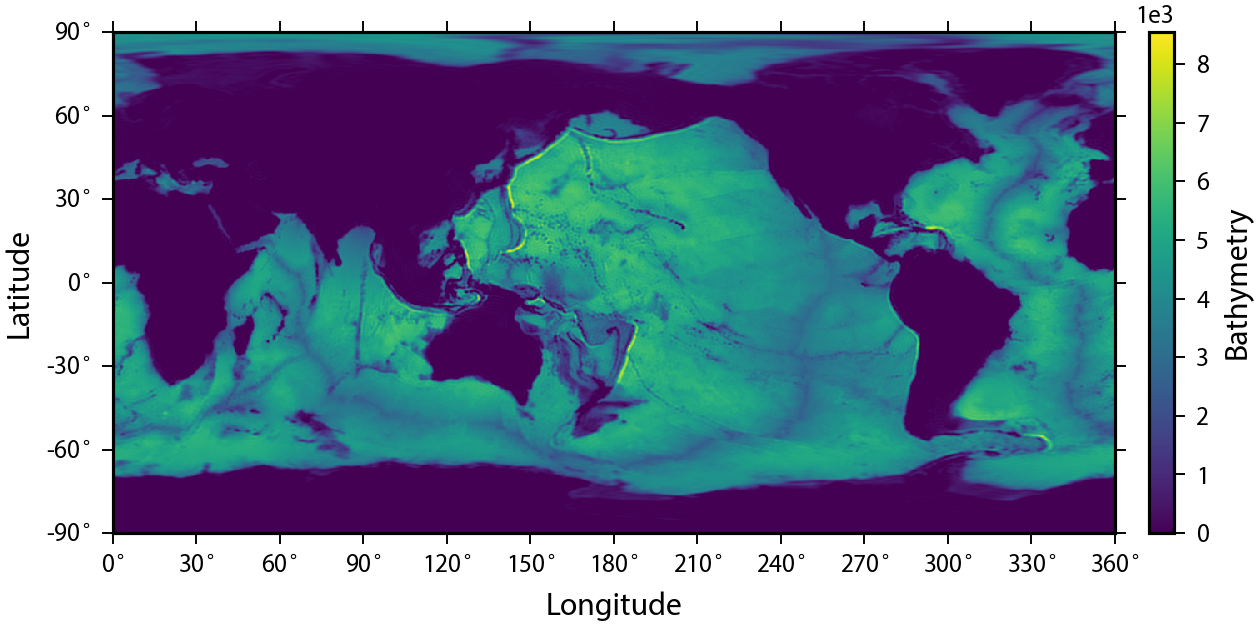

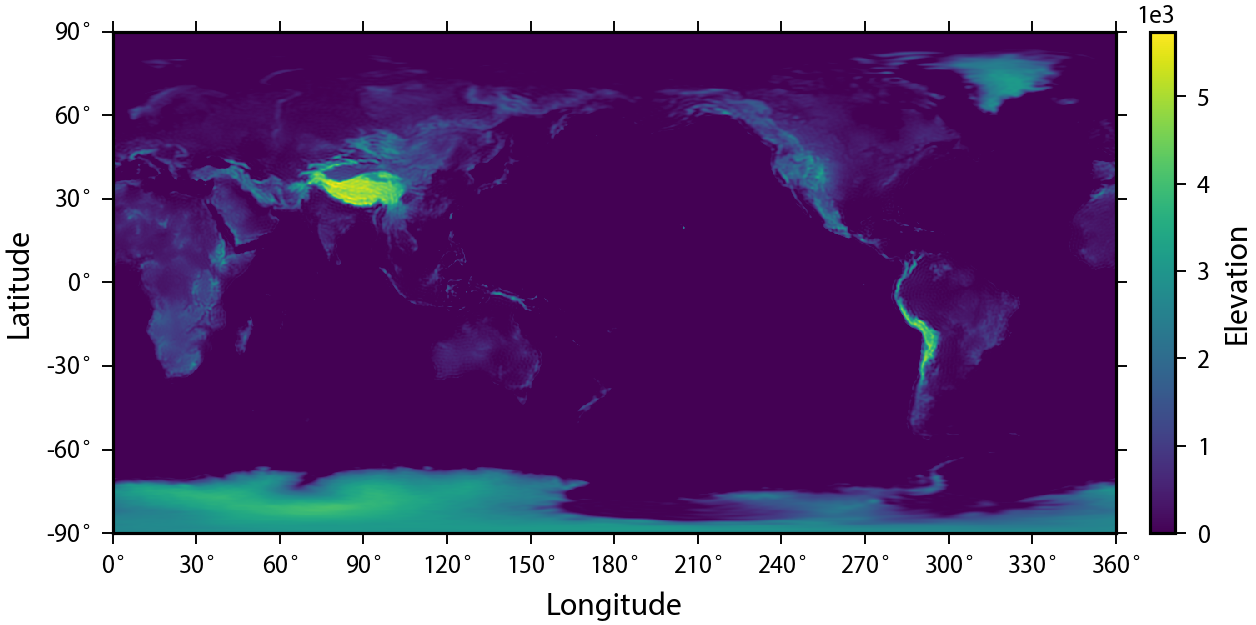

In [4]:
fig, ax = (topo * ocean_mask *(-1)).plot(colorbar=True, cb_label='Bathymetry')
fig2, ax2 = (topo * land_mask).plot(colorbar=True, cb_label='Elevation')

## Optimally concentrated window functions

SHTOOLS provides a method to solve the so called *concentration problem*, that is, to find windows with a specified maximum spherical harmonic degree `lmax` that are optimally concentrated in the region of interest. The smaller the region, the larger `lmax` will need to be to allow for a good concentration. Because the oceans span a larger area than the land mass, the spherical harmonic bandwidth of the ocean windows `lmax_ocean` can be smaller than the spherical harmonic bandwidth of the land windows `lmax_land` while still providing the same number of well concentrated windows. 

Creating localization windows is easy using the `SHWwindow` method `from_mask()`. All we need to do is provide the mask, the maximum spherical harmonic bandwidth, and optionally, the number of windows to return:

In [5]:
lmax_ocean = 9
lmax_land = 21
nwins = 10

ocean_windows = pyshtools.SHWindow.from_mask(ocean_mask.to_array(), lmax_ocean, nwin=nwins)
land_windows = pyshtools.SHWindow.from_mask(land_mask.to_array(), lmax_land, nwin=nwins)

We can find out information about the windows that were created using the `info()` method, and the windows can be plotted using the `plot_windows()` method. In plotting the windows, the *loss factor* of the window is provided above each image, which is the proportion of the energy of the window that lies outside the region of interest. This is simply 1 minus the *concentration factor*. For our example, it is seen that in order to obtain 10 well localized windows with loss factors of less than 0.1%, the spectral bandwidth of the land windows needs to be more than twice as large as that of the ocean windows.

In [ ]:
ocean_windows.info()
fig, ax = ocean_windows.plot_windows(nwins, maxcolumns=2)

kind = 'mask'
lwin = 9
nwin = 10
shannon = 70.691436
area (radians) = 8.883348e+00
Taper weights are not set


In [ ]:
land_windows.info()
fig2, ax2 = land_windows.plot_windows(nwins, maxcolumns=2)

The following plot shows the power spectra of all windows. In particular, it is noted that the power of the land windows extends to higher degrees than does the ocean windows. The ocean windows will thus allow for spectral estimates with lower biasses given the lower bandwidth of these windows.

In [ ]:
winpower_land = land_windows.spectra()
winpower_ocean = ocean_windows.spectra()

degrees_land = land_windows.degrees()
degrees_ocean = ocean_windows.degrees()

fig, ax = plt.subplots(1, 1)
for itaper in range(nwins):
    ax.plot(degrees_ocean, winpower_ocean[:, itaper], c='blue')
    
for itaper in range(nwins):
    ax.plot(degrees_land, winpower_land[:, itaper], c='green')

ax.set(xlabel='Spherical harmonic degree', ylabel='power per degree',
       title='Ocean (blue) and land (green) window power');

## The coupling matrix

We next plot the coupling matrix associated with the land and ocean windows. The coupling matrix relates the statistical expectation of the windowed power spectrum to that of the global unwindowed power spectrum. For this example, we will assume that the topography of Earth is known only to degree 60.

In [ ]:
lmax_data = 60

lmax_valid1 = lmax_data - lmax_ocean
lmax_full1 = lmax_data + lmax_ocean

fig1, ax1 = ocean_windows.plot_coupling_matrix(lmax_data, k=nwins, mode='full', show=False)
ax1.axhline(lmax_valid1, c='red')
ax1.text(1, lmax_valid1 + 3, 'affected by degrees > lmax_data', fontsize=12, color='red')
ax1.set(xlim=[-0.5, lmax_data + 0.5], ylim=[lmax_full1, 0.], title='ocean coupling matrix')

lmax_valid2 = lmax_data - lmax_land
lmax_full2 = lmax_data + lmax_land

fig2, ax2 = land_windows.plot_coupling_matrix(lmax_data, k=nwins, mode='full', show=False)
ax2.axhline(lmax_valid2, c='red')
ax2.text(1, lmax_valid2 + 4, 'affected by degrees > lmax_data', fontsize=12, color='red')
ax2.set(xlim=[-0.5, lmax_data + 0.5], ylim=[lmax_full2, 0.], title='land coupling matrix');

The above plotted coupling matrices reflects the different quality of the land and ocean spectra. The higher degree part (towards the bottom right) corresponds to a simple convolution, as it becomes asymptotically symmetric about the diagonal. The land windows (bottom) couple degrees over a wider range and therefore decrease the spectral resolution that can be achieved.

It is also seen that the coupling matrix is asymmetric at the lowest degrees. Here, low input degrees map to higher output degrees. For example, the input degree 0 maps strongest to about degree 3 in the ocean case and to about degree 8 in the land case. This is a consequence of the fact that we can not estimate the global mean or very large wavelength structures from subregions that are much smaller than the feature of interest. Low degree energy maps therefore to the lowest window degrees, where they increase the overall power.

A given localized spectral estimate at degree `l` contains information from the global field between degrees `l-lwin` and `l+lwin`. For this example, we assumed that the data were expanded to degree 60. The red line in these plots thus denotes the degree where the localized spectral esimates contain information from beyond the maximum degree of the data. In general, one should only interpret the localized spectrum up to a maximum degree `lmax_data - lwin`. This corresponds to the case where the coupling matrix is created with the option `mode='valid'`.

### Regional spectral estimates

We are now in a position to compute regional power spectral estimates of the land and of the ocean topography as well as the corresponding power spectra that we would *expect* to see on land and in the ocean if Earth's topography was stationary and isotropic (which it isn't).

We first calculate the global power spectrum:

In [ ]:
power_global = clm.spectrum()
lmax_global = clm.lmax
degrees_global = clm.degrees()

Next, we use the methods `multitaper_spectrum()` to determine the multitaper power spectrum of the oceans and land, and then we calculate the expected spectrum if the Earth's topography was stationary and isostropic. For the later, we use the dot product of the coupling matrix and global spectrum, but we also could have used the method `biased_spectrum()` to obtain the same thing:

In [ ]:
power_ocean, dpower_ocean = ocean_windows.multitaper_spectrum(clm, nwins)
power_land, dpower_land = land_windows.multitaper_spectrum(clm, nwins)

cmatrix_ocean = ocean_windows.coupling_matrix(lmax_global, k=nwins, mode='valid')
power_ocean_predicted = np.dot(cmatrix_ocean, power_global)
degrees_ocean_power = np.arange(len(power_ocean_predicted))

cmatrix_land = land_windows.coupling_matrix(lmax_global, k=nwins, mode='valid')
power_land_predicted = np.dot(cmatrix_land, power_global)
degrees_land_power = np.arange(len(power_land_predicted))

Finally, let's plot the measured and predicted multitaper power spectra:

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.plot(degrees_global, power_global, c='grey', alpha=0.5, lw=2, label='Global')
ax.plot(degrees_ocean_power, power_ocean, '-', c='blue', label='Ocean, observed')
ax.plot(degrees_ocean_power, power_ocean_predicted, '--', c='blue', label='Ocean, expectation')
ax.plot(degrees_land_power, power_land, '-', c='green', label='Land, observed')
ax.plot(degrees_land_power, power_land_predicted, '--', c='green', label='Land, expectation')
ax.set(xscale='log', yscale='log', xlabel='Spherical harmonic degree', ylabel='Power')
ax.legend(loc=1)
ax.grid(True)

As we should have expected, the power spectra are vastly different. For degrees greater than the window bandwidths, the observed ocean spectrum is seen to be significantly lower than that of the land spectrum up until about degree 100.  The ocean spectrum has high power for degrees less than the window bandwidth because the average elevation of ocean is much less than 0. The land spectrum is entirely missing the low degree component because the land elevations don't deviate much from 0.

This plot also shows that the predicted and observed spectra for the oceans and land are vastly different. This is simply a reflection of the fact that Earth's topopgraphy is not stationary and isostropic, and that there are in fact major differences between the oceans and land. The global power spectrum is simply not appropriate for estimating the localized spectrum.

We next show that the measured and expected spectra would have been more similar if the topography was in fact a stationary process. We illustrate this by replacing the observed topography of Earth with a random model that has the same expectation for the power spectrum. First, we create new topography from random coefficients:

In [ ]:
coeffs_stationary = pyshtools.SHCoeffs.from_random(power_global, seed=12345)
grid_stationary = coeffs_stationary.expand(grid='DH2')

Let's plot the masked topography of this synthetic dataset:

In [ ]:
fig, ax = (grid_stationary * ocean_mask *(-1)).plot(colorbar=True, cb_label='Bathymetry')
fig2, ax2 = (grid_stationary * land_mask).plot(colorbar=True, cb_label='Elevation')

Next, we proceed as above and calculate the relevant multitaper spectra:

In [ ]:
power_ocean, dpower_ocean = ocean_windows.multitaper_spectrum(coeffs_stationary, nwins)
power_land, dpower_land = land_windows.multitaper_spectrum(coeffs_stationary, nwins)

cmatrix_ocean = ocean_windows.coupling_matrix(lmax_global, k=nwins, mode='valid')
power_ocean_predicted = np.dot(cmatrix_ocean, power_global)

cmatrix_land = land_windows.coupling_matrix(lmax_global, k=nwins, mode='valid')
power_land_predicted = np.dot(cmatrix_land, power_global)

fig, ax = plt.subplots(1, 1)

ax.plot(degrees_global, power_global, c='grey', alpha=0.5, lw=2, label='Global')
ax.plot(degrees_ocean_power, power_ocean, '-', c='blue', label='Ocean, observed')
ax.plot(degrees_ocean_power, power_ocean_predicted, '--', c='blue', label='Ocean, expectation')
ax.plot(degrees_land_power, power_land, '-', c='green', label='Land, observed')
ax.plot(degrees_land_power, power_land_predicted, '--', c='green', label='Land, expectation')
ax.set(title='Regional spectra of a stationary random model', xscale='log', yscale='log',
       xlabel='Spherical harmonic degree', ylabel='Power')
ax.legend(loc=1)
ax.grid(True)

In this case, the regional estimates of the stationary model resemble closely the predicted ones. The lowest degrees are more sensitive to fluctuations of the random model given that these spectral estimates where constructed based on a smaller number of localized coefficients.

To compare global, ocean and land spectra, the coupling matrix can be *inverted* to remove the bias. In the case of the stationary model, we expect to retrieve the same original input power spectrum, because apart from random fluctuations, the differences of the power spectra are entirely due to the window effects. In the case of the real non-stationary topography of the Earth on the other hand, we would get three power spectra that correspond to equivalent stationary global models that have the observed regional spectra. This inversion, however, has to be done with care, because the coupling matrix is singular.